<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/overview_Jan9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install datasets -q


In [ ]:
import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset,random_split
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [36]:
model_name="places-xlstm-1"

from google.colab import drive
drive.mount('/content/drive')

import os

CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"ckpt saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"no ckpt found for {model_name} starting from epoch 0.")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"ckpt loaded for {model_name} from {ckpt_path}. resuming from epoch {start_epoch}.")

    return start_epoch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")
print("Path to dataset files:", path)

100%|██████████| 2.12G/2.12G [01:18<00:00, 28.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2


In [44]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import glob
from torchvision import transforms

def visualize_random_images(data_path, num_images=5):
    """
    Visualize random images from the dataset
    """
    # Get all image paths
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    # Select random images
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Create subplot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for idx, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Image {idx+1}')

    plt.tight_layout()
    plt.show()

def create_random_mask(size, mask_ratio=0.2):
    """
    Create a random rectangular mask
    """
    height, width = size
    mask = np.ones((height, width), np.float32)

    # Calculate random rectangle dimensions
    mask_height = int(height * np.sqrt(mask_ratio))
    mask_width = int(width * np.sqrt(mask_ratio))

    # Calculate random position
    top = random.randint(0, height - mask_height)
    left = random.randint(0, width - mask_width)

    # Apply mask
    mask[top:top + mask_height, left:left + mask_width] = 0
    return mask

def process_and_visualize_masked_images(data_path, num_samples=5, target_size=(256, 256)):
    """
    Process images with masks and visualize results
    """
    # Get image paths
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    # Select random images
    selected_images = random.sample(image_paths, min(num_samples, len(image_paths)))

    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    # Create visualization grid
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))

    for idx, img_path in enumerate(selected_images):
        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)

        # Create mask
        mask = create_random_mask(target_size)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        # Apply mask to image
        masked_img = img_tensor * mask_tensor

        # Convert tensors back to numpy for visualization
        orig_img = img_tensor.permute(1, 2, 0).numpy()
        mask_viz = mask_tensor.permute(1, 2, 0).numpy()
        masked_img = masked_img.permute(1, 2, 0).numpy()

        # Plot
        axes[0, idx].imshow(orig_img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title('Original')

        axes[1, idx].imshow(mask_viz, cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title('Mask')

        axes[2, idx].imshow(masked_img)
        axes[2, idx].axis('off')
        axes[2, idx].set_title('Masked')

    plt.tight_layout()
    plt.show()

def create_masked_dataset(data_path, num_images=1000, target_size=(256, 256)):
    """
    Create a dataset of original and masked images
    """
    # Get all image paths
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    # Select random images
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    dataset = []
    for img_path in selected_images:
        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)

        # Create mask
        mask = create_random_mask(target_size)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        # Apply mask to image
        masked_img = img_tensor * mask_tensor

        dataset.append({
            'original': img_tensor,
            'masked': masked_img,
            'mask': mask_tensor
        })

    return dataset

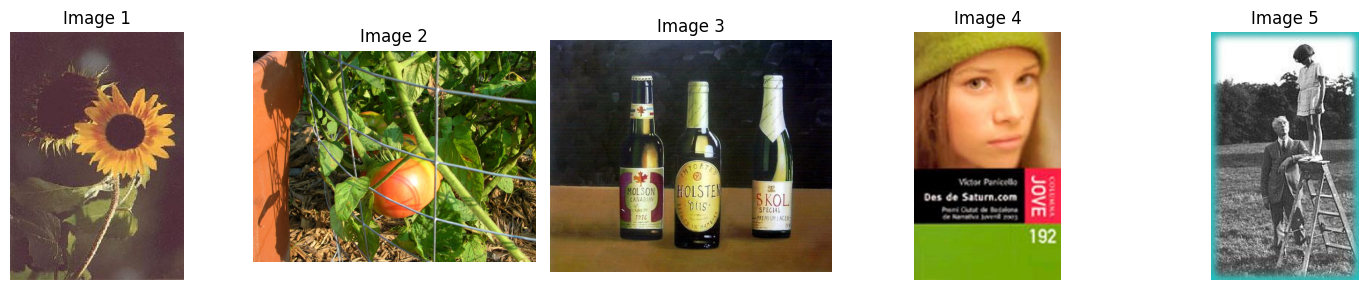

In [42]:
visualize_random_images(path, num_images=5)

NameError: name 'width_mask' is not defined

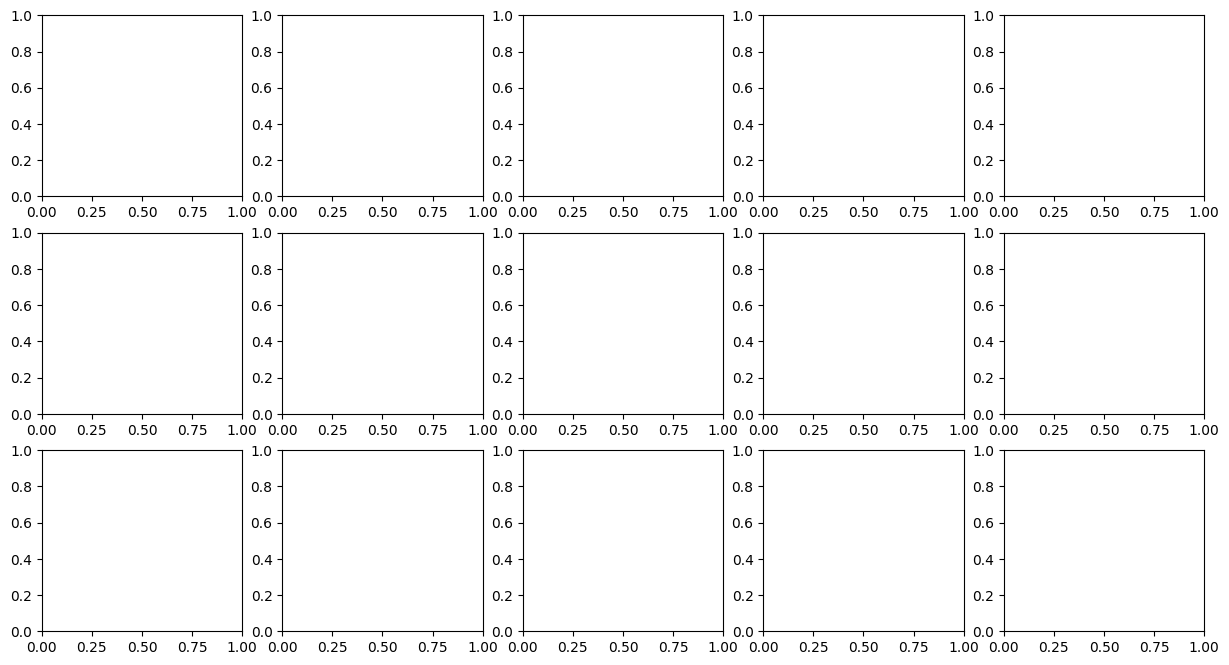

In [43]:
# Visualize 5 images with their masks
process_and_visualize_masked_images(path, num_samples=5)